<a href="https://colab.research.google.com/github/Kprerak-iisc/data-science/blob/master/credit_card.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!ls /content/gdrive/'My Drive/Colab Notebooks/Fraud'

credit_card.ipynb  data  fraud.ipynb


 In this notebook we will develop a few ML models using anonymized credit card transaction data. The challenge behind fraud detection is that frauds are far less common as compared to legal transactions

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use('bmh')

In [5]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Fraud/data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Non-fraud transactions: 99.83%
Fraud transactions: 0.17%


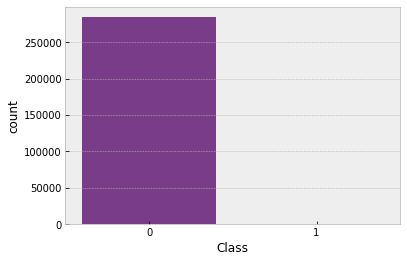

In [ ]:
sns.countplot(x='Class', data=df, palette='CMRmap')
print('Non-fraud transactions: {}%'.format(round(df.Class.value_counts()[0]/len(df)*100.0,2)))
print('Fraud transactions: {}%'.format(round(df.Class.value_counts()[1]/len(df)*100.0,2)))

In [ ]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


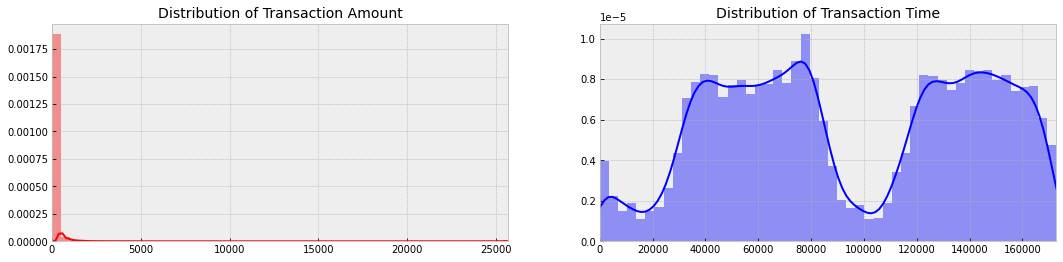

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

This dataset is severely imbalanced(most of the transactions are non-fraud). So the algorithms are much more likely to classify new observations to the majority class and high accuracy won't tell us anything. SMOTE (Synthetic Minority Oversampling Technique) is a type of oversampling method, which we are going to use to make our dataset balanced. It creates synthetic points from the minority class.
we shouldn't use accuracy score as a metric with imbalanced datasets (will be usually high and misleading), instead we should use f1-score, precision/recall score for measuring performance. 

**normalize the distribution using Feature Scaling. In our case it is better to use the Robust Scaler algorithm because it's robust to outliers**

In [7]:
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
df['scaled_amount'] = rs.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rs.fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Time', 'Amount'], axis=1, inplace=True)

In [8]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(0, 'scaled_time', scaled_time)
df.head()

,scaled_time,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-0.994983,1.783274,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.994983,-0.269825,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,-0.994972,4.983721,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,-0.994972,1.418291,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.994960,0.670579,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


**Logistic Regression Without SMOTE**

              precision    recall  f1-score   support

   Non-fraud       1.00      1.00      1.00     56861
       Fraud       0.88      0.63      0.74       101

    accuracy                           1.00     56962
   macro avg       0.94      0.82      0.87     56962
weighted avg       1.00      1.00      1.00     56962



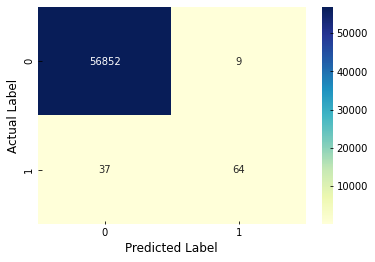

In [9]:
from sklearn.model_selection import train_test_split as holdout
x = np.array(df.iloc[:, df.columns != 'Class'])
y = np.array(df.iloc[:, df.columns == 'Class'])
x_train, x_test, y_train, y_test = holdout(x, y, test_size=0.2, random_state=0)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report, precision_score, recall_score, accuracy_score
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

labels = ['Non-fraud', 'Fraud']
print(classification_report(y_test, y_pred, target_names=labels))

This is not a good model, because it is biased towards majority class and the recall in minority class is not as high as desired

**Applying SMOTE**

Transaction Number x_train dataset:  (227845, 30)
Transaction Number y_train dataset:  (227845, 1)
Transaction Number x_test dataset:  (56962, 30)
Transaction Number y_test dataset:  (56962, 1)
Before OverSampling, counts of label '1': [391]
Before OverSampling, counts of label '0': [227454] 

After OverSampling, the shape of train_x: (454908, 30)
After OverSampling, the shape of train_y: (454908,) 

After OverSampling, counts of label '1', %: 50.0
After OverSampling, counts of label '0', %: 50.0


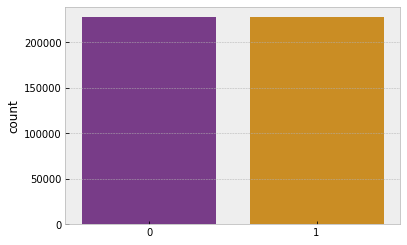

In [10]:
from imblearn.over_sampling import SMOTE

print("Transaction Number x_train dataset: ", x_train.shape)
print("Transaction Number y_train dataset: ", y_train.shape)
print("Transaction Number x_test dataset: ", x_test.shape)
print("Transaction Number y_test dataset: ", y_test.shape)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
x_train_s, y_train_s = sm.fit_sample(x_train, y_train.ravel())

print('After OverSampling, the shape of train_x: {}'.format(x_train_s.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_s.shape))

print("After OverSampling, counts of label '1', %: {}".format(sum(y_train_s==1)/len(y_train_s)*100.0,2))
print("After OverSampling, counts of label '0', %: {}".format(sum(y_train_s==0)/len(y_train_s)*100.0,2))

sns.countplot(x=y_train_s, data=df, palette='CMRmap')

Now the dataset is balanced, so we can build a Logistic Regression model with SMOTE. One important thing to point out here is that we used SMOTE after cross validation in order to avoid data leakage problem and hence overfitting

**Logistic Regression with SMOTE**

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56861
           1       0.06      0.94      0.12       101

    accuracy                           0.98     56962
   macro avg       0.53      0.96      0.55     56962
weighted avg       1.00      0.98      0.99     56962



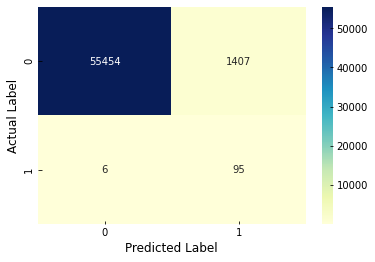

In [11]:
logreg = LogisticRegression()
logreg.fit(x_train_s, y_train_s)
y_pred = logreg.predict(x_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

print(classification_report(y_test, y_pred))

Text(0.5, 1.0, 'Precision Recall Curve')

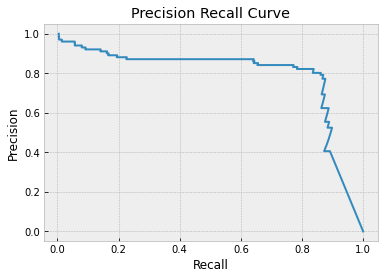

In [12]:
y_pred_prob = logreg.predict_proba(x_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')

We got a high recall which means our model is able to detect the highest number of fraud transactions, while the precision is very low which is not good because it means that the model classifies a lot of non-fraud transactions as fraud. The customers of a financial institution are not going to be satisfied with that fact and may even stop using the service of that financial institution. So in this case it's also important to have a high precision, which we are going to try to achieve with Random Forest

**Random Forest Classifier with SMOTE**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.88      0.83      0.86       101

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



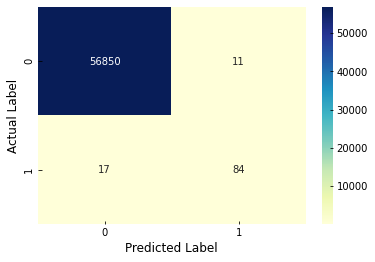

In [13]:
from sklearn.ensemble import RandomForestClassifier as rfc
rand_f = rfc(n_estimators=1000, min_samples_split=10, min_samples_leaf=1,
           max_features='auto', max_leaf_nodes=None,
           oob_score=True, n_jobs=-1, random_state=1)
rand_f.fit(x_train_s, y_train_s)
y_pred = rand_f.predict(x_test)

cnf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

print(classification_report(y_test, y_pred))

Text(0.5, 1.0, 'Precision Recall Curve')

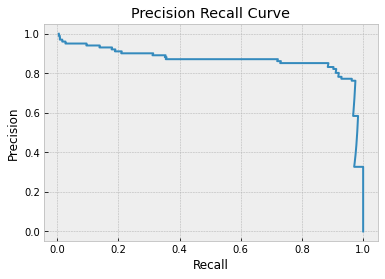

In [14]:
y_pred_prob = rand_f.predict_proba(x_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')

 Random Forest with SMOTE performed better than Logistic Regression overall allowing us to get high recall and high precision at the same time. Even though the recall has decreased a little bit, we were able to increase the precision significantly, which means a lot in the case of fraud detection and as we know it is a trade-off

**Plotting Feature Importances**

Feature importance ranking


1.V14(0.172874)
2.V10(0.136764)
3.V4(0.102636)
4.V12(0.095637)
5.V17(0.081462)
6.V11(0.079414)
7.V3(0.044849)
8.V16(0.038896)
9.V7(0.029036)
10.V2(0.022649)
11.V9(0.020200)
12.V18(0.017011)
13.V8(0.016003)
14.V21(0.012785)
15.V1(0.012529)
16.V5(0.012093)
17.V19(0.010716)
18.V6(0.010573)
19.V27(0.010107)
20.scaled_amount(0.009083)
21.V20(0.008815)
22.V28(0.008423)
23.V13(0.008313)
24.scaled_time(0.006916)
25.V26(0.006050)
26.V15(0.005710)
27.V25(0.005492)
28.V23(0.005287)
29.V22(0.004919)
30.V24(0.004757)


<BarContainer object of 30 artists>

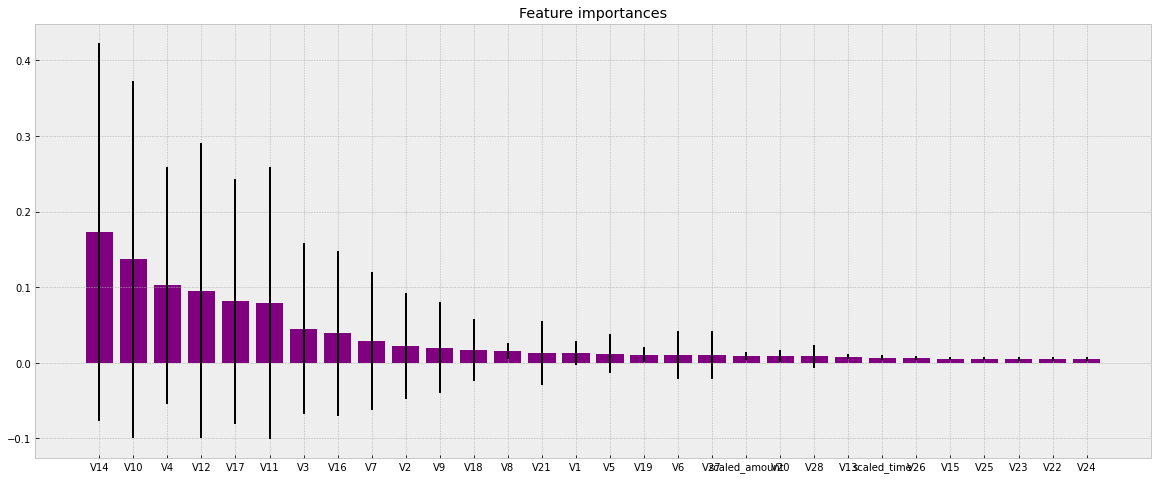

In [15]:
print('Feature importance ranking\n\n')
importances = rand_f.feature_importances_
std = np.std([tree.feature_importances_ for tree in rand_f.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
variables = df.columns
importance_list = []
for f in range(x.shape[1]):
    variable = variables[indices[f]]
    importance_list.append(variable)
    print("%d.%s(%f)" % (f + 1, variable, importances[indices[f]]))
plt.figure(figsize=(20, 8))
plt.title("Feature importances")
plt.bar(importance_list, importances[indices],
       color="purple", yerr=std[indices], align='center')

**XGBoost**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.84      0.84      0.84       101

    accuracy                           1.00     56962
   macro avg       0.92      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



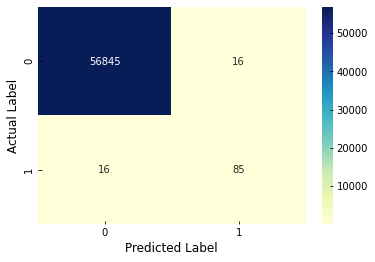

In [16]:
import xgboost as xgb
model = xgb.XGBClassifier(n_estimators = 5000, max_depth = 30, learning_rate = 0.01)
model.fit(x_train_s, y_train_s)
y_pred = model.predict(x_test)

cnf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

print(classification_report(y_test, y_pred))

**Conclusion:**
Good prediction results can be achieved with imbalanced datasets as well as with balanced ones
Random Forest and XGBoost Classifiers gave us the best results being able to detect more than 80% fraud transactions and at the same time not classifying a lot of non-fraud transactions as fraud
There is no perfect model and there will always be a trade-off between precision and recall. It is up to the company and its objectives to decide which approach is the best in each particular situation